# Calculate temperature time series for Vienna from 1959-2022

This script is based on parts of https://github.com/ProjectPythia/ERA5_interactive-cookbook/blob/main/notebooks/01BasicVisualization.ipynb.

We also show at the end that the calculation is consistent with the Copernicus Interactive Climate Atlas, https://atlas.climate.copernicus.eu/atlas.

Load libraries.

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.spatial
import numpy as np
import cf_xarray as cfxr

Check content of Google Cloud storage.

In [2]:
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/ar')

['gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg_der

We load the version on with data from years 1959 to 2022, with data every 6 hours and on a 0.7 deg lon x 0.7 deg lat grid.

In [3]:
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr', 
    consolidated=True,
    chunks={'time': 1e6}, # note: inhibit chunking in time since we later work on the single grid point of Vienna over all time steps
)

The data set has a size of more than 4 TB! But do not worry, we do not need to download all of it. Instead we work with subsets of the data.

In [4]:
print(f'size: {reanalysis.nbytes / (1024 ** 4)} TB')

size: 4.740127285193012 TB


But first, let us check the content of the data set. Among other variables, it contains the 2m temperature. time is the time steps, ranging from 1959 to 2022 in 6-hour steps.

In [5]:
reanalysis

<xarray.Dataset> Size: 5TB
Dimensions:                                           (time: 92044,
                                                       longitude: 512,
                                                       latitude: 256, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 2kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 4kB ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 48GB dask.array<chunksize=(92044, 512, 256), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 48GB dask.array<chunksize=(92044, 512, 256), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 48GB dask.array<chunksize=(92044, 512, 256), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 48GB dask.array<chunksize=(92044, 512, 256), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 524kB dask.array<chunksize=(512, 256), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 524kB dask.array<chunksize=(512, 256), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 524kB dask.array<chunksize=(512, 256), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 524kB dask.array<chunksize=(512, 256), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 627GB dask.array<chunksize=(92044, 13, 512, 256), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 627GB dask.array<chunksize=(92044, 13, 512, 256), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 627GB dask.array<chunksize=(92044, 13, 512, 256), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 627GB dask.array<chunksize=(92044, 13, 512, 256), meta=np.ndarray>

Select 2m temperature for further analysis.

In [6]:
t2m = reanalysis["2m_temperature"]

t2m has the dimensions time x longitude x latitude.

In [7]:
t2m.shape

(92044, 512, 256)

Let us plot the first time seto for illustration. This shows the 2m temperature on a map.

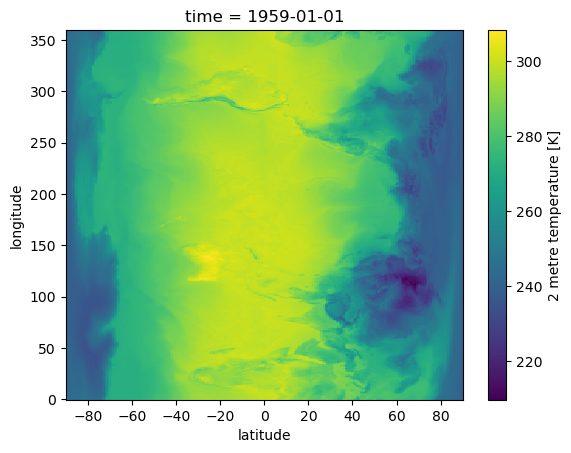

In [8]:
t2m.isel(time=0).plot()
plt.savefig("t2m-globalmap-firsttimesteps.pdf")

Now let us select the grid point for Vienna. The latitude of Vienna, Austria is 48.210033N, and the longitude is 16.363449E. 

In [9]:
vienna = t2m.sel(latitude=48.2, longitude=16.4, method="nearest")

Subsetting for t2m and for Vienna has massively decreased the size of the data.

In [10]:
print(f'size: {vienna.nbytes / (1024 ** 4)} TB')

size: 3.3485412131994963e-07 TB


For illustration, this is the time series of 2m temperature of Vienna for the first 100 time steps.

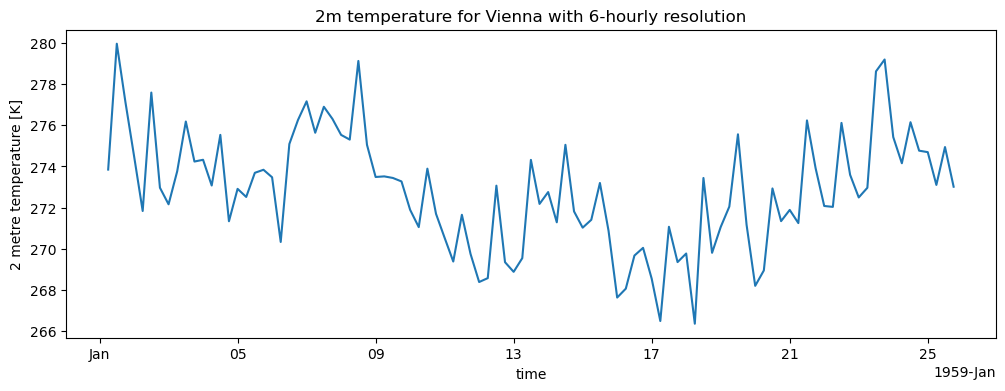

In [11]:
plt.figure(figsize=(12,4))
vienna[1:100].plot()
plt.title("2m temperature for Vienna with 6-hourly resolution")

plt.savefig("t2m-vienna-first100timesteps.pdf")

Let us now compute the annual mean of the 2m temperature for Vienna.

In [12]:
vienna_year = vienna.groupby(vienna.time.dt.year).mean()

And finally, let us plot the time series of the annual mean Vienna temperature. Attention: this can take several minutes as a lot of hidden lazy computations are now triggered.

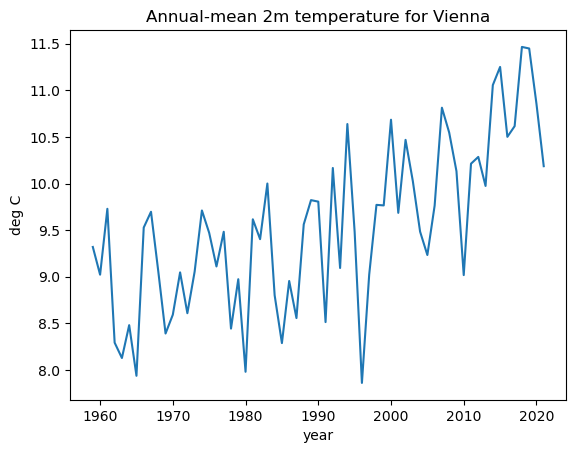

In [13]:
(vienna_year-273.15).plot()
plt.title("Annual-mean 2m temperature for Vienna")
plt.ylabel("deg C")

plt.savefig("t2m-vienna-annualmean-from-1959-2022.pdf")

The computed time series matches the one that one can get from the Copernicus Interactive Climate Atlas by manually selecting a region for Vienna. So all is consistent - as it should be!

https://atlas.climate.copernicus.eu/atlas

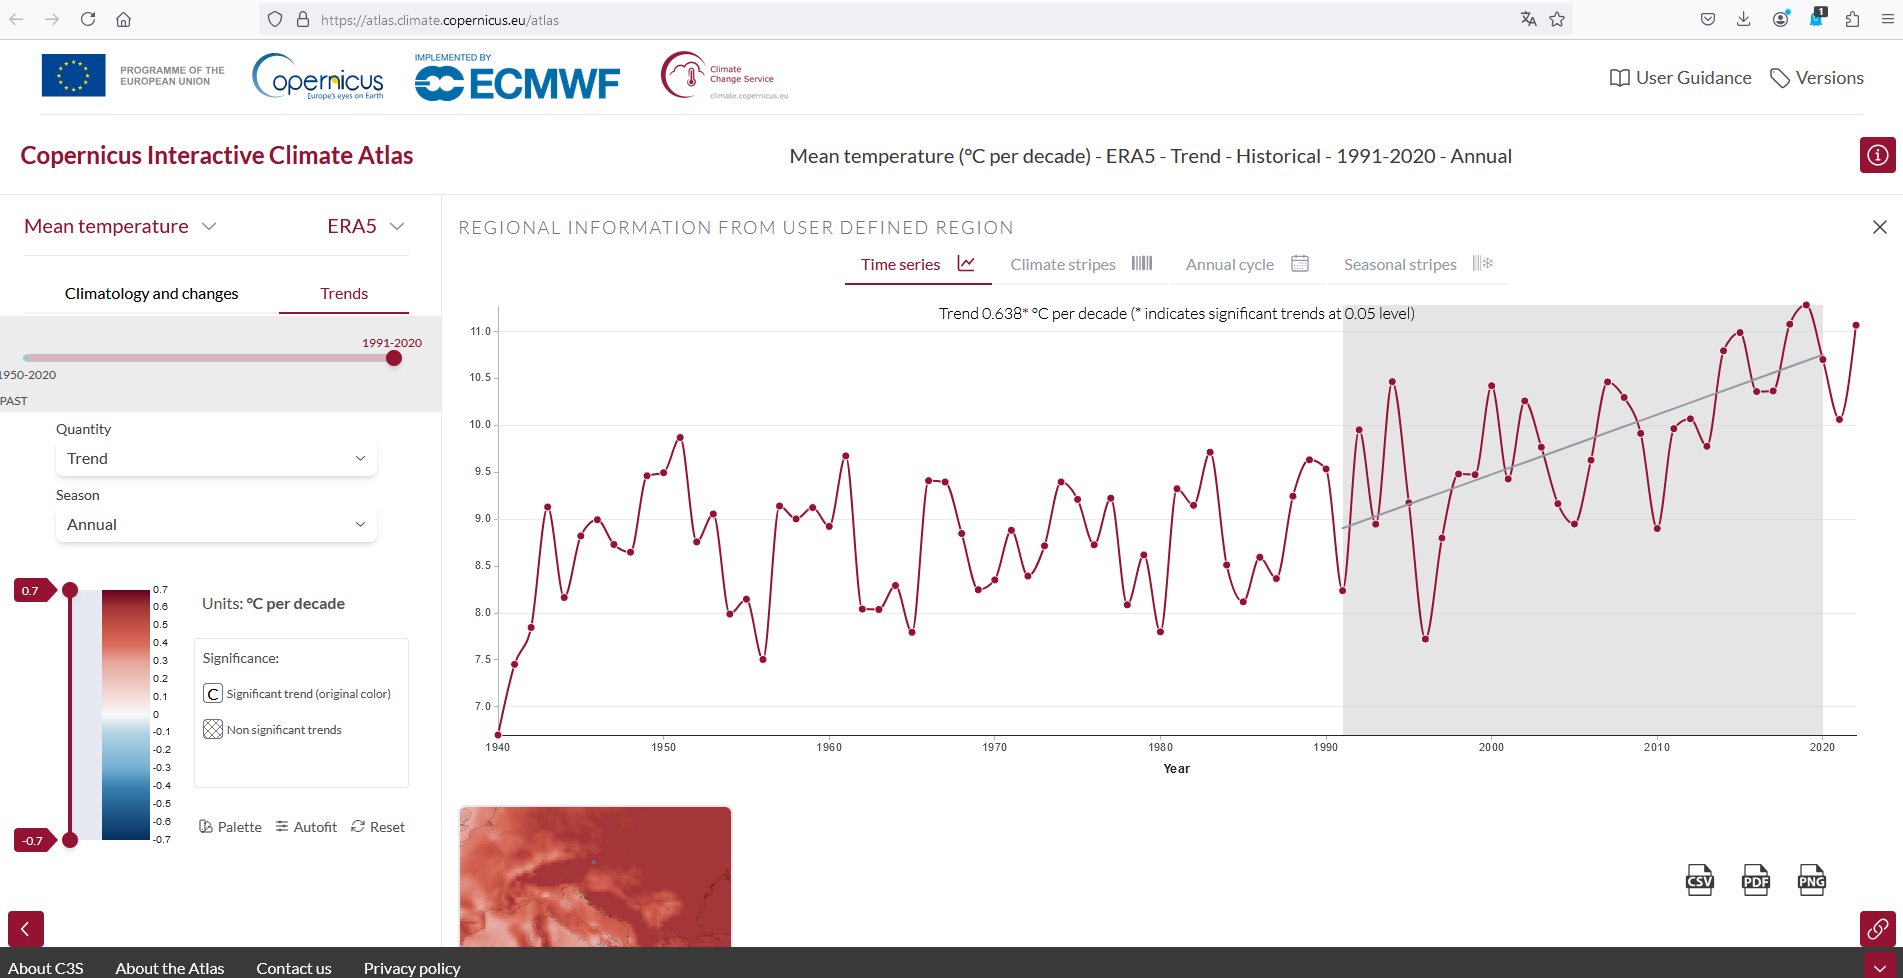

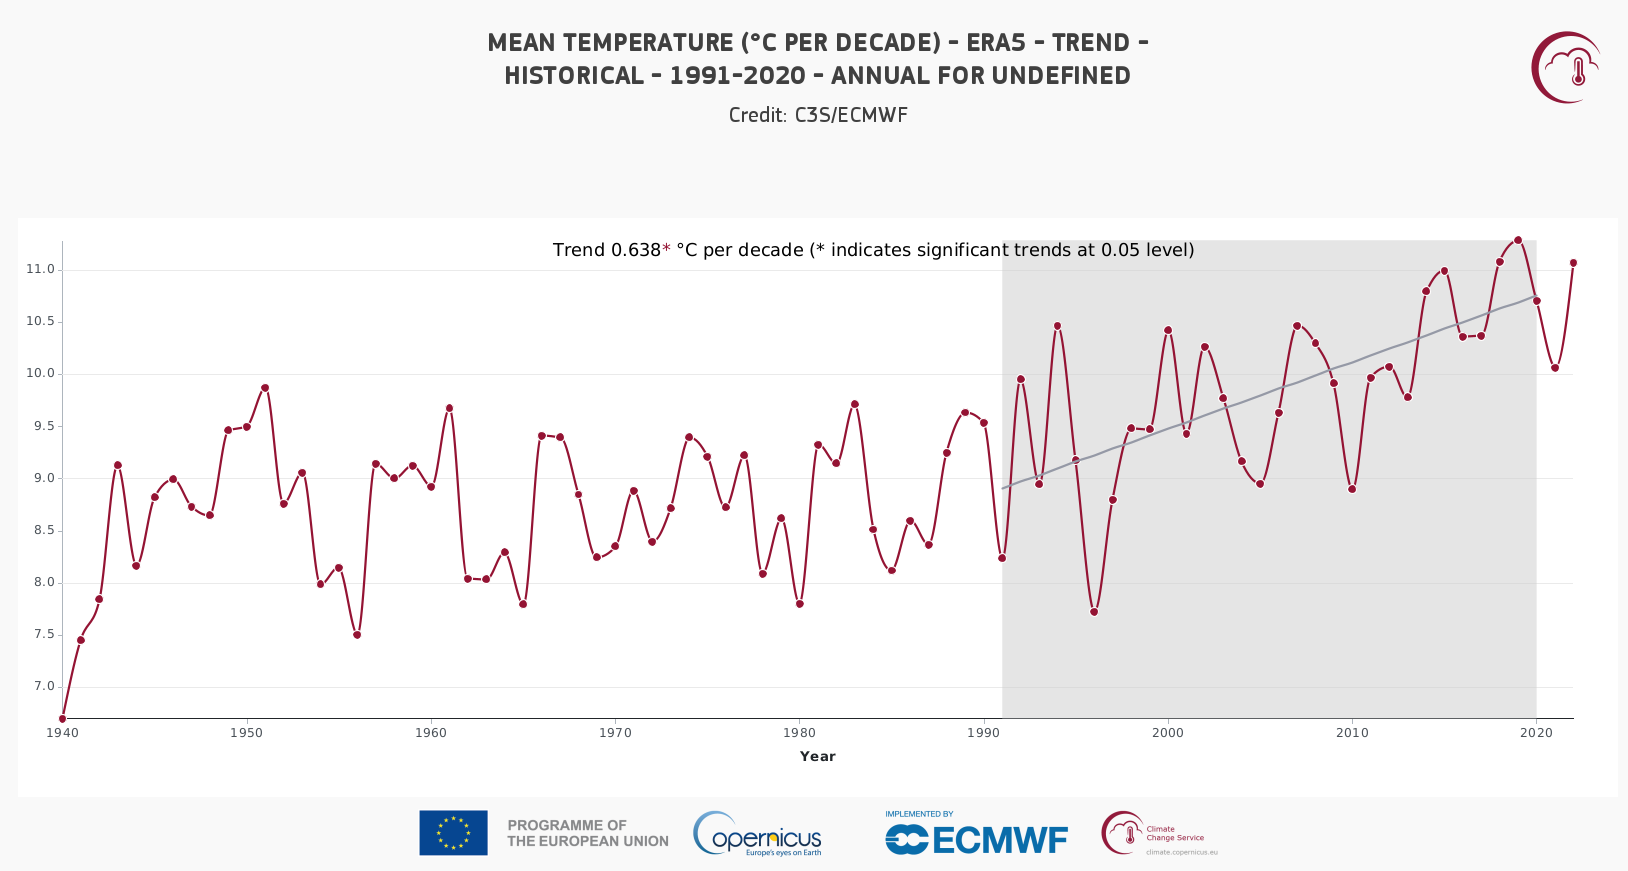